In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

In [3]:
# Load datasets
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('test_without_label.csv')

In [4]:
# Convert volume strings to numerical values
def convert_volume(vol):
    if isinstance(vol, str):
        if 'M' in vol:
            return float(vol.replace('M', '')) * 1e6
        elif 'K' in vol:
            return float(vol.replace('K', '')) * 1e3
        else:
            return float(vol)
    return float(vol)

train_df['Vol.'] = train_df['Vol.'].apply(convert_volume)
val_df['Vol.'] = val_df['Vol.'].apply(convert_volume)
test_df['Vol.'] = test_df['Vol.'].apply(convert_volume)


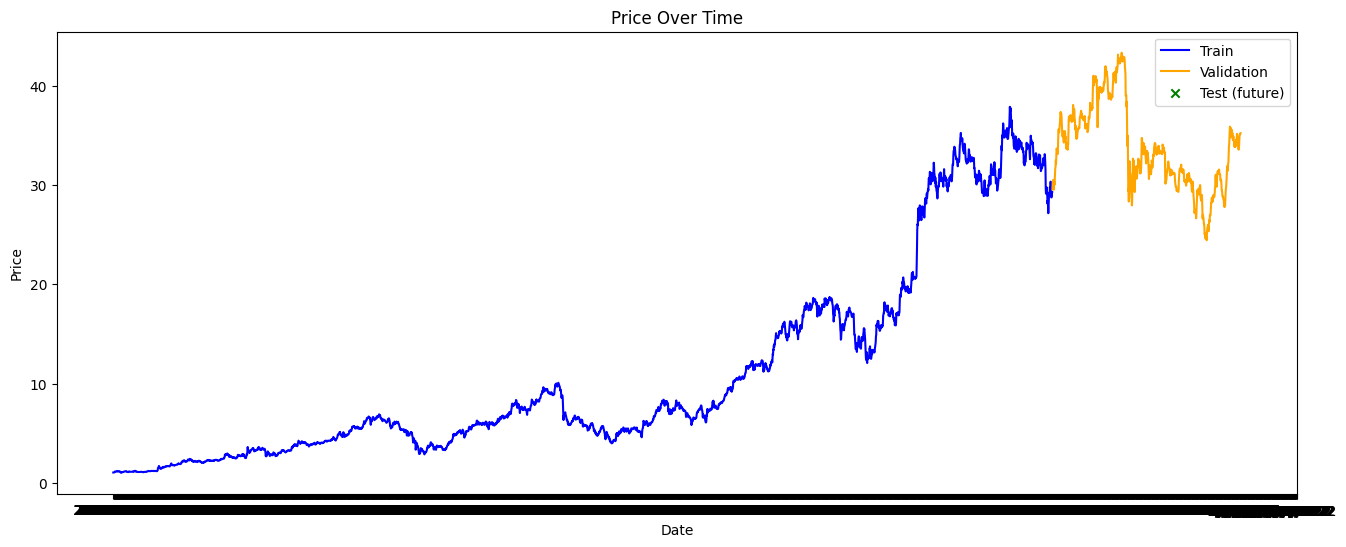

In [5]:
# Visualize the Price over time for train, val, and test (with test as future dates)
plt.figure(figsize=(16, 6))
plt.plot(train_df['Date'], train_df['Price'], label='Train', color='blue')
plt.plot(val_df['Date'], val_df['Price'], label='Validation', color='orange')
plt.scatter(test_df['Date'], [None]*len(test_df), label='Test (future)', color='green', marker='x')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.legend()
plt.show()

In [6]:
# Add 'Price' column with NaN to test_df
test_df['Price'] = np.nan

# Parse dates
train_df['Date'] = pd.to_datetime(train_df['Date'], format='%Y-%m-%d')
val_df['Date'] = pd.to_datetime(val_df['Date'], format='%Y-%m-%d')
test_df['Date'] = pd.to_datetime(test_df['Date'], format='%m/%d/%Y')

# Combine and sort
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True).sort_values('Date').reset_index(drop=True)

# Define feature columns
feature_cols = ['Open', 'High', 'Low', 'Vol.']

In [7]:
# Scale features based on training data
train_end_date = train_df['Date'].max()
feature_scaler = MinMaxScaler()
feature_scaler.fit(combined_df[combined_df['Date'] <= train_end_date][feature_cols])
combined_df[feature_cols] = feature_scaler.transform(combined_df[feature_cols])

# Scale target
target_scaler = MinMaxScaler()
target_scaler.fit(combined_df[combined_df['Date'] <= train_end_date][['Price']])


MinMaxScaler()

In [8]:
# Sequence length
N = 18

# Create all sequences
def create_all_sequences(df, sequence_length, feature_columns):
    X = []
    for i in range(sequence_length, len(df)):
        sequence = df.iloc[i - sequence_length : i + 1][feature_columns].values
        X.append(sequence)
    return np.array(X)

X_all = create_all_sequences(combined_df, N, feature_cols)

In [9]:
# Define indices
train_indices = [i for i in range(N, len(combined_df)) if combined_df.iloc[i]['Date'] <= train_end_date]
val_start_date = val_df['Date'].min()
val_end_date = val_df['Date'].max()
val_indices = [i for i in range(N, len(combined_df)) if combined_df.iloc[i]['Date'] >= val_start_date and combined_df.iloc[i]['Date'] <= val_end_date]
test_indices = [i for i in range(N, len(combined_df)) if not pd.isna(combined_df.iloc[i]['ID'])]

# Verify test_indices length
print(f"Number of test indices: {len(test_indices)}")  # Should be 728


Number of test indices: 728


In [10]:
# Prepare data
X_train = np.array([X_all[i - N] for i in train_indices])
y_train = combined_df.iloc[train_indices]['Price'].values
y_train_scaled = target_scaler.transform(y_train.reshape(-1, 1))

X_val = np.array([X_all[i - N] for i in val_indices])
y_val = combined_df.iloc[val_indices]['Price'].values
y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1))

X_test = np.array([X_all[i - N] for i in test_indices])
ids_test = combined_df.iloc[test_indices]['ID'].values

c:\Users\mooma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\mooma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [11]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)


In [ ]:
# Build and train model
model = Sequential()
model.add(LSTM(64, input_shape=(N + 1, len(feature_cols))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model.fit(X_train, y_train_scaled, epochs=100, batch_size=16, validation_data=(X_val, y_val_scaled), 
          callbacks=[early_stopping], verbose=0.5)


c:\Users\mooma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


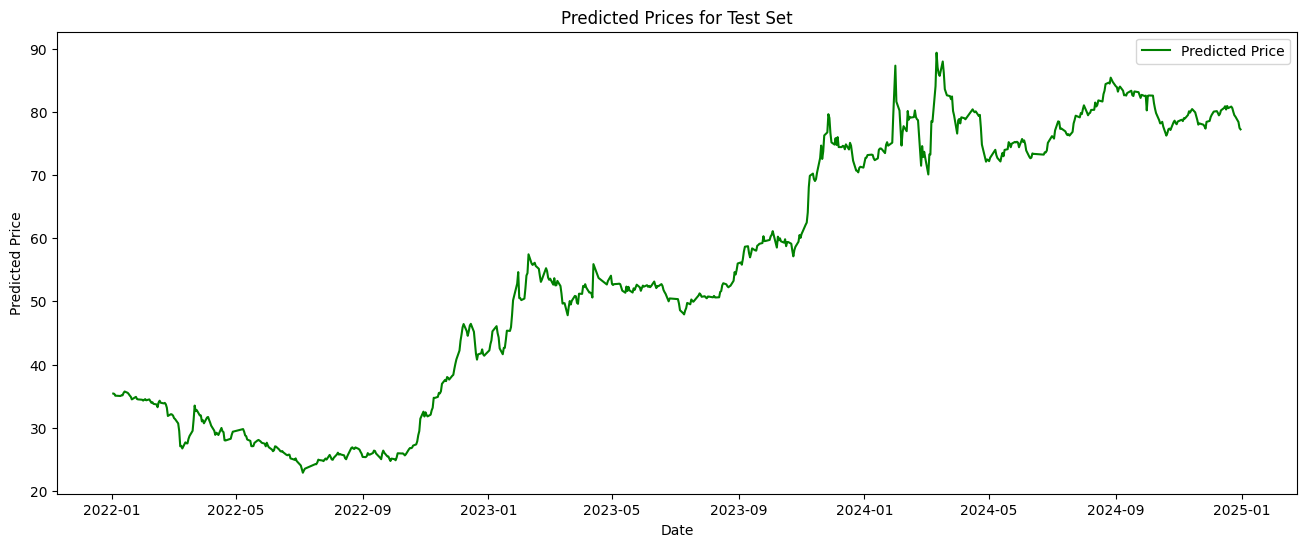

In [13]:
# Predict
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
# Visualize predicted prices for the test set
plt.figure(figsize=(16, 6))
plt.plot(test_df['Date'], y_pred, label='Predicted Price', color='green')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.title('Predicted Prices for Test Set')
plt.legend()
plt.show()


In [14]:
# Create submission
submission_df = pd.DataFrame({'ID': ids_test, 'Price': y_pred.flatten()})
submission_df['ID'] = submission_df['ID'].astype(int)
submission_df.to_csv('submission.csv', index=False)

print(f"Output rows: {len(submission_df)}")  # Should be 728

Output rows: 728
